In [1]:
import os
import sys
import glob
import torch
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter

sys.path.insert(0, os.path.expanduser('./yield-forecast-torch'))

In [2]:
from yieldforecast.data import make_input
from yieldforecast.model import YieldModule
from yieldforecast.train import train, nll_loss, combined_loss

In [42]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

plt.style.use('bmh')
plt.rc('font',**{'family':'sans-serif','sans-serif':['', 'Arial', 'Helvetica']})
font = {'family' : 'Liberation Sans',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=False)

In [4]:
TIMESTEPS = {
    'brazil': {
        'rice': range(1, 9),
        'corn': range(1, 10),
        'cotton': range(1, 10),
        'soybean': range(1, 10),
        'sugarcane': range(1, 13),
    }
}
TIMESTEPS.update({
    k: {'soybean': range(5, 11)} for k in (
            'illinois iowa minnesota ohio nebraska indiana us '
            'north_dakota missouri south_dakota arkansas'
        ).split()
})

In [5]:
import numpy as np
import pandas as pd
import torch.utils.data as tdata

from pprint import pprint
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score

BU_ACRE_TO_METRIC_TONNES = 67.25106937166726

METRICS = {
    'R2': r2_score,
    'MAE': mean_absolute_error,
    'MSE': mean_squared_error,
    'MAPE': lambda x, y: mean_absolute_percentage_error(x, y),
    'Correlation': lambda x, y: np.corrcoef(x, y)[0][1],
}


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def get_error_metrics(df):
    return {name: metric(df['test'], df['pred']) for name, metric in METRICS.items()}

def evaluate(model, inputs, y, scaler, batch_size=512, device='cuda'):
    dynamic, static = inputs
    if not isinstance(dynamic, torch.Tensor):
        dynamic = torch.from_numpy(dynamic)

    if not isinstance(static, torch.Tensor):
        static = torch.from_numpy(static)

    dataset = tdata.TensorDataset(
        dynamic, static
    )

    dataloader = tdata.DataLoader(
        dataset, batch_size=batch_size
    )

    pred = []
    with torch.no_grad():
        for dyn, stat in dataloader:
            pred.append(model(dyn.to(device), stat.to(device)))
    std = np.hstack([p.stddev.detach().cpu().numpy().reshape((-1,)) for p in pred]).squeeze().reshape((-1, 1))
    pred = np.hstack([p.mean.detach().cpu().numpy().reshape((-1,)) for p in pred]).squeeze().reshape((-1, 1))

    df = pd.DataFrame(
        {
            'pred': scaler.inverse_transform(pred).reshape((-1,)),
            'test': scaler.inverse_transform(y).reshape((-1,)),
            'std': scaler.inverse_transform(std).reshape((-1,)),
        },
        index=range(len(pred))
    ) * BU_ACRE_TO_METRIC_TONNES

    try:
        metrics = get_error_metrics(df)
        pprint(metrics)
    except ValueError:
        logger.exception(
            'Failed to evaluate model. Probably with ∞ or NaN in network output.'
        )
        return None

    return df

In [44]:
from scipy.stats import norm
from scipy.special import gdtrix

def plot_reliability(df, crop, scaler, step=0.01):
    x = np.arange(0, 1. + step, step)

    pj_test = []
    for alpha in x:
        # alpha = 0.95
        # (1 - alpha) / 2 <-> (1 - alpha/2)
        bottom = norm.ppf(q=(1 - alpha) / 2, loc=df['pred'], scale=df['std'])
        top = norm.ppf(q=1 - (1 - alpha) / 2, loc=df['pred'], scale=df['std'])
        pj_test.append(
            ((df['test'] <= top) & (df['test'] >= bottom)).mean()
        )

    plt.figure(figsize=(8.0, 8.0))
    plt.plot(x, pj_test, label='Computed')
    plt.plot(x, x, '--', label='Ideal')
    plt.xlabel('Expected confidence level')
    plt.ylabel('Observed confidence level')
    plt.title(f'Reliability plot for {crop}')
    plt.legend()
    plt.tight_layout(pad=.1)
    plt.savefig(f'reliability-{crop}.pdf')

def plot_scatter(df, crop, scaler):
    fig = plt.figure(figsize=(8.0, 8.0))
    plt.scatter(df['test'], df['pred'], c=df['std'])
    c = plt.colorbar(orientation='horizontal')
    h = c.ax.set_xlabel("Uncertainty")
    c.ax.get_xaxis().set_ticks([])
    for j, label in enumerate('low medium high'.split()):
        c.ax.text(
            (2 * j + 1) / 6, .5, label, va='center', ha='center',
            color='white' if j != 1 else 'black', transform=c.ax.transAxes
        )

    y_lim = plt.ylim()
    x_lim = plt.xlim()
    lim = max(x_lim, y_lim)
    locs, vals = plt.xticks()
    plt.yticks(locs, vals)
    plt.plot(lim, lim, 'k-')
    plt.ylim(lim)
    plt.xlim(lim)
    plt.xlabel('Actual (kg/ha)')
    plt.ylabel('Predicted (kg/ha)')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(
        mpl.ticker.ScalarFormatter(useMathText=True)
    )
    ax.xaxis.set_major_formatter(
        mpl.ticker.ScalarFormatter(useMathText=True)
    )
    ax.ticklabel_format(axis='both', style='sci', scilimits=(-2, 2))
    plt.tight_layout(pad=.1)
    plt.savefig(f'uncertainty-{region}-{crop}.pdf')

In [7]:
def next_run(crop, region):
    runs = glob.glob(f'runs/{region}-{crop}*')
    return len(runs) + 1

In [8]:
crop = 'soybean'
region = 'brazil'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
path = (Path(os.path.expanduser('./yield-forecast-torch/data')) / f'{region}-{crop}-input.csv').absolute()
data = make_input(path, 'out', use_ndvi=False, timesteps=TIMESTEPS[region][crop],
                  use_all_soilgrids_layers=False, year=2018)

In [9]:
checkpoint_template = f'{region}-{crop}-%s-weights.pth'

In [10]:
import logging
logging.basicConfig(level=logging.INFO)

In [11]:
device

'cuda'

In [12]:
def loss(target, dist):
    return nll_loss(target, dist) - 1e-1 * dist.entropy().mean()

In [13]:
import optuna

def objective(trial):
    entropy = trial.suggest_uniform('entropy', 0, .5)
    α = trial.suggest_loguniform('α', 1e-7, 1e-4)
    noise = trial.suggest_uniform('noise', 0, 0.2)
    gamma = trial.suggest_uniform('gamma', 0, .9)

    def current_loss(target, dist):
        return nll_loss(target, dist) - entropy * dist.entropy().mean()

    model = YieldModule().to(device)
    train(
        model, data['X_train'], data['y_train'], data['train_years'],
        α=α, patience=25, epochs=1000, device=device, noise=noise, writer=None,
        checkpoint_template=checkpoint_template, step_size=512, gamma=gamma,
        loss=current_loss
    )
    model.load_state_dict(torch.load(f'{region}-{crop}-best-weights.pth'))
    df = evaluate(model, data['X_test'], data['y_test'], data['y_scaler'])
    return -np.corrcoef(df.pred, df.test)[0, 1]

In [14]:
try:
    study = optuna.create_study(study_name='soybean', storage='sqlite:///studies.db')
except:
    study = optuna.load_study(study_name='soybean', storage='sqlite:///studies.db')
study.optimize(objective, n_trials=20)

INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -1.027E-01 ± 6.903E-01, valid loss: -1.320E+00 ± 4.518E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -1.360E+00 ± 7.419E-02, valid loss: -1.369E+00 ± 4.795E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -1.376E+00 ± 5.877E-02, valid loss: -1.356E+00 ± 1.335E-01 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -1.373E+00 ± 9.508E-02, valid loss: -1.392E+00 ± 5.422E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -1.388E+00 ± 9.865E-02, valid loss: -1.374E+00 ± 4.929E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -1.378E+00 ± 7.315E-02, valid loss: -1.379E+00 ± 1.001E-01 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -1.380E+00 ± 9.140E-02, valid loss: -1.422E+00 ± 4.858E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -1.392E+00 ± 9.426E-02, valid loss: -1.389E+00 ± 6.531E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.36008644630894415,
 'MAE': 482.74222,
 'MAPE': 14.883211255073547,
 'MSE': 390267.9,
 'R2': -0.2723608823022603}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -6.585E-01 ± 6.905E-01, valid loss: -1.262E+00 ± 4.193E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -1.250E+00 ± 5.876E-02, valid loss: -1.287E+00 ± 5.095E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -1.249E+00 ± 7.574E-02, valid loss: -1.244E+00 ± 3.145E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -1.255E+00 ± 8.335E-02, valid loss: -1.271E+00 ± 4.876E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -1.260E+00 ± 8.958E-02, valid loss: -1.290E+00 ± 6.490E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -1.267E+00 ± 7.761E-02, valid loss: -1.285E+00 ± 5.689E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -1.278E+00 ± 4.725E-02, valid loss: -1.229E+00 ± 1.393E-01 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -1.278E+00 ± 6.351E-02, valid loss: -1.292E+00 ± 3.222E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.3940976237664675,
 'MAE': 467.04388,
 'MAPE': 14.451983571052551,
 'MSE': 371704.44,
 'R2': -0.2118398067297398}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -7.113E-01 ± 6.610E-01, valid loss: -1.198E+00 ± 4.440E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -1.197E+00 ± 6.308E-02, valid loss: -1.224E+00 ± 5.023E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -1.201E+00 ± 6.822E-02, valid loss: -1.193E+00 ± 1.024E-01 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -1.213E+00 ± 6.278E-02, valid loss: -1.205E+00 ± 1.095E-01 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -1.216E+00 ± 8.032E-02, valid loss: -1.228E+00 ± 3.429E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -1.206E+00 ± 9.394E-02, valid loss: -1.243E+00 ± 2.758E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -1.220E+00 ± 6.958E-02, valid loss: -1.200E+00 ± 1.346E-01 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -1.225E+00 ± 6.383E-02, valid loss: -1.198E+00 ± 1.293E-01 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.40469765327483703,
 'MAE': 431.38333,
 'MAPE': 13.521246612071991,
 'MSE': 332782.84,
 'R2': -0.08494668169223929}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -5.515E-01 ± 6.740E-01, valid loss: -1.107E+00 ± 1.046E-01 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -1.140E+00 ± 5.439E-02, valid loss: -1.126E+00 ± 1.375E-01 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -1.141E+00 ± 7.169E-02, valid loss: -1.161E+00 ± 4.623E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -1.147E+00 ± 5.781E-02, valid loss: -1.114E+00 ± 9.477E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -1.144E+00 ± 7.666E-02, valid loss: -1.138E+00 ± 3.949E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -1.149E+00 ± 5.743E-02, valid loss: -1.169E+00 ± 4.376E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -1.151E+00 ± 6.994E-02, valid loss: -1.166E+00 ± 4.348E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -1.142E+00 ± 6.936E-02, valid loss: -1.167E+00 ± 3.161E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.39987259395886937,
 'MAE': 445.34412,
 'MAPE': 13.86258751153946,
 'MSE': 350244.28,
 'R2': -0.1418747939889613}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -3.226E-01 ± 6.914E-01, valid loss: -1.124E+00 ± 9.219E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -1.138E+00 ± 5.988E-02, valid loss: -1.133E+00 ± 3.068E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -1.137E+00 ± 6.978E-02, valid loss: -1.124E+00 ± 9.252E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -1.145E+00 ± 5.672E-02, valid loss: -1.126E+00 ± 8.988E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -1.150E+00 ± 4.468E-02, valid loss: -1.132E+00 ± 1.048E-01 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -1.150E+00 ± 7.497E-02, valid loss: -1.164E+00 ± 4.469E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -1.143E+00 ± 8.297E-02, valid loss: -1.178E+00 ± 2.120E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -1.150E+00 ± 6.941E-02, valid loss: -1.150E+00 ± 3.098E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.3675663301989918,
 'MAE': 505.3924,
 'MAPE': 15.488578379154205,
 'MSE': 424026.78,
 'R2': -0.38242246495630283}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -7.229E-01 ± 6.566E-01, valid loss: -1.168E+00 ± 7.726E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -1.201E+00 ± 5.943E-02, valid loss: -1.218E+00 ± 4.235E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -1.213E+00 ± 6.711E-02, valid loss: -1.182E+00 ± 5.440E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -1.201E+00 ± 7.950E-02, valid loss: -1.236E+00 ± 4.233E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -1.213E+00 ± 7.809E-02, valid loss: -1.206E+00 ± 5.890E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -1.218E+00 ± 8.645E-02, valid loss: -1.228E+00 ± 4.734E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -1.222E+00 ± 6.655E-02, valid loss: -1.184E+00 ± 1.416E-01 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -1.237E+00 ± 7.474E-02, valid loss: -1.234E+00 ± 1.260E-01 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.43219132566643687,
 'MAE': 413.20273,
 'MAPE': 12.993903458118439,
 'MSE': 319328.28,
 'R2': -0.04108182507298852}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -6.823E-01 ± 6.157E-01, valid loss: -1.189E+00 ± 4.870E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -1.199E+00 ± 5.633E-02, valid loss: -1.214E+00 ± 4.518E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -1.209E+00 ± 4.518E-02, valid loss: -1.178E+00 ± 1.218E-01 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -1.210E+00 ± 6.278E-02, valid loss: -1.216E+00 ± 3.442E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -1.199E+00 ± 6.783E-02, valid loss: -1.209E+00 ± 3.472E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -1.223E+00 ± 6.807E-02, valid loss: -1.207E+00 ± 4.635E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -1.211E+00 ± 8.400E-02, valid loss: -1.205E+00 ± 4.062E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -1.227E+00 ± 4.128E-02, valid loss: -1.185E+00 ± 1.240E-01 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.3881500718005621,
 'MAE': 464.54764,
 'MAPE': 14.341722428798676,
 'MSE': 374431.12,
 'R2': -0.22072949570568778}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -6.728E-01 ± 5.218E-01, valid loss: -1.077E+00 ± 5.279E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -1.076E+00 ± 6.564E-02, valid loss: -1.078E+00 ± 3.724E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -1.081E+00 ± 6.721E-02, valid loss: -1.096E+00 ± 4.206E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -1.094E+00 ± 5.252E-02, valid loss: -1.076E+00 ± 1.077E-01 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -1.088E+00 ± 6.516E-02, valid loss: -1.110E+00 ± 4.383E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -1.093E+00 ± 7.571E-02, valid loss: -1.085E+00 ± 2.820E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -1.095E+00 ± 6.389E-02, valid loss: -1.106E+00 ± 3.669E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -1.102E+00 ± 6.749E-02, valid loss: -1.108E+00 ± 3.434E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.3817521824555684,
 'MAE': 419.12198,
 'MAPE': 13.254547119140625,
 'MSE': 323005.44,
 'R2': -0.053070057053626885}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.461E-01 ± 7.212E-01, valid loss: -1.180E+00 ± 4.344E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -1.181E+00 ± 6.177E-02, valid loss: -1.207E+00 ± 4.657E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -1.194E+00 ± 6.244E-02, valid loss: -1.195E+00 ± 6.068E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -1.195E+00 ± 6.457E-02, valid loss: -1.162E+00 ± 1.107E-01 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -1.188E+00 ± 7.028E-02, valid loss: -1.196E+00 ± 4.331E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -1.191E+00 ± 7.478E-02, valid loss: -1.205E+00 ± 5.452E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -1.200E+00 ± 6.923E-02, valid loss: -1.166E+00 ± 1.376E-01 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -1.199E+00 ± 8.395E-02, valid loss: -1.194E+00 ± 3.995E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.38178177594019747,
 'MAE': 477.152,
 'MAPE': 14.711903035640717,
 'MSE': 386612.97,
 'R2': -0.26044492841721345}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -7.556E-01 ± 6.309E-01, valid loss: -1.205E+00 ± 5.894E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -1.214E+00 ± 5.225E-02, valid loss: -1.190E+00 ± 8.923E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -1.211E+00 ± 7.182E-02, valid loss: -1.229E+00 ± 3.349E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -1.218E+00 ± 8.350E-02, valid loss: -1.238E+00 ± 5.801E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -1.228E+00 ± 7.150E-02, valid loss: -1.237E+00 ± 4.081E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -1.239E+00 ± 7.988E-02, valid loss: -1.237E+00 ± 2.389E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -1.257E+00 ± 7.287E-02, valid loss: -1.276E+00 ± 3.765E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -1.257E+00 ± 9.815E-02, valid loss: -1.317E+00 ± 3.667E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.38871105444126597,
 'MAE': 412.8554,
 'MAPE': 13.053250312805176,
 'MSE': 318164.5,
 'R2': -0.037287643957316874}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -1.390E-01 ± 7.568E-01, valid loss: -1.208E+00 ± 3.504E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -1.246E+00 ± 6.542E-02, valid loss: -1.271E+00 ± 3.339E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -1.259E+00 ± 7.708E-02, valid loss: -1.271E+00 ± 4.218E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -1.269E+00 ± 4.988E-02, valid loss: -1.239E+00 ± 1.024E-01 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -1.258E+00 ± 8.468E-02, valid loss: -1.274E+00 ± 2.596E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -1.263E+00 ± 7.324E-02, valid loss: -1.267E+00 ± 4.450E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -1.269E+00 ± 7.424E-02, valid loss: -1.262E+00 ± 4.855E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -1.272E+00 ± 7.970E-02, valid loss: -1.277E+00 ± 4.214E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.37017414837907353,
 'MAE': 483.0212,
 'MAPE': 14.879447221755981,
 'MSE': 392566.72,
 'R2': -0.27985552107733236}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -5.317E-01 ± 6.331E-01, valid loss: -1.137E+00 ± 4.214E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -1.129E+00 ± 7.302E-02, valid loss: -1.151E+00 ± 4.407E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -1.134E+00 ± 7.502E-02, valid loss: -1.129E+00 ± 4.056E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -1.143E+00 ± 5.391E-02, valid loss: -1.120E+00 ± 8.774E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -1.136E+00 ± 7.361E-02, valid loss: -1.132E+00 ± 3.140E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -1.142E+00 ± 9.782E-02, valid loss: -1.147E+00 ± 3.211E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -1.141E+00 ± 6.585E-02, valid loss: -1.152E+00 ± 3.776E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -1.152E+00 ± 6.045E-02, valid loss: -1.154E+00 ± 4.516E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.26412366033772544,
 'MAE': 489.38147,
 'MAPE': 15.239062905311584,
 'MSE': 415387.97,
 'R2': -0.3542578857593892}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: 2.121E-01 ± 1.998E-01, valid loss: -3.108E-01 ± 2.225E-03 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -9.147E-01 ± 2.016E-01, valid loss: -1.031E+00 ± 4.197E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -1.029E+00 ± 5.471E-02, valid loss: -1.044E+00 ± 3.922E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -1.030E+00 ± 5.741E-02, valid loss: -1.044E+00 ± 2.744E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -1.035E+00 ± 6.409E-02, valid loss: -1.042E+00 ± 2.093E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -1.039E+00 ± 6.210E-02, valid loss: -1.041E+00 ± 4.464E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -1.038E+00 ± 6.144E-02, valid loss: -1.059E+00 ± 3.045E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -1.046E+00 ± 6.478E-02, valid loss: -1.009E+00 ± 7.357E-02 
INFO:yieldforecast.train.train:Epoch: 009

{'Correlation': 0.3543061031632093,
 'MAE': 508.473,
 'MAPE': 15.560764074325562,
 'MSE': 427165.12,
 'R2': -0.3926541481173027}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -6.337E-01 ± 5.917E-01, valid loss: -1.111E+00 ± 4.084E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -1.098E+00 ± 5.557E-02, valid loss: -1.075E+00 ± 1.174E-01 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -1.106E+00 ± 4.081E-02, valid loss: -1.022E+00 ± 1.106E-01 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -1.103E+00 ± 5.722E-02, valid loss: -1.098E+00 ± 4.106E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -1.107E+00 ± 6.868E-02, valid loss: -1.121E+00 ± 3.937E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -1.102E+00 ± 8.247E-02, valid loss: -1.117E+00 ± 3.388E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -1.105E+00 ± 8.603E-02, valid loss: -1.117E+00 ± 5.054E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -1.120E+00 ± 4.971E-02, valid loss: -1.088E+00 ± 8.318E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.367238189654511,
 'MAE': 446.4505,
 'MAPE': 13.918085396289825,
 'MSE': 355555.6,
 'R2': -0.15919100958712762}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -3.079E-01 ± 6.521E-01, valid loss: -1.137E+00 ± 2.970E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -1.154E+00 ± 6.308E-02, valid loss: -1.135E+00 ± 1.490E-01 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -1.161E+00 ± 4.714E-02, valid loss: -1.145E+00 ± 1.113E-01 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -1.156E+00 ± 6.822E-02, valid loss: -1.172E+00 ± 4.592E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -1.161E+00 ± 7.065E-02, valid loss: -1.164E+00 ± 3.730E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -1.164E+00 ± 5.570E-02, valid loss: -1.164E+00 ± 4.410E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -1.166E+00 ± 7.518E-02, valid loss: -1.182E+00 ± 2.881E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -1.163E+00 ± 8.433E-02, valid loss: -1.174E+00 ± 4.718E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.3958228767190398,
 'MAE': 446.19186,
 'MAPE': 13.87457549571991,
 'MSE': 352769.47,
 'R2': -0.15010759968598153}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: 6.493E-02 ± 3.440E-01, valid loss: -8.814E-01 ± 8.473E-03 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -1.045E+00 ± 6.223E-02, valid loss: -1.041E+00 ± 9.039E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -1.070E+00 ± 5.247E-02, valid loss: -1.076E+00 ± 4.692E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -1.071E+00 ± 6.424E-02, valid loss: -1.074E+00 ± 4.717E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -1.073E+00 ± 4.998E-02, valid loss: -1.074E+00 ± 2.621E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -1.072E+00 ± 6.196E-02, valid loss: -1.078E+00 ± 4.039E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -1.070E+00 ± 6.198E-02, valid loss: -1.074E+00 ± 3.779E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -1.076E+00 ± 6.173E-02, valid loss: -1.092E+00 ± 3.615E-02 
INFO:yieldforecast.train.train:Epoch: 009

{'Correlation': 0.37476066763219246,
 'MAE': 462.57272,
 'MAPE': 14.332476258277893,
 'MSE': 369242.75,
 'R2': -0.20381422203476718}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.325E-01 ± 6.993E-01, valid loss: -1.189E+00 ± 4.936E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -1.205E+00 ± 7.541E-02, valid loss: -1.227E+00 ± 3.009E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -1.213E+00 ± 7.493E-02, valid loss: -1.214E+00 ± 3.323E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -1.220E+00 ± 7.315E-02, valid loss: -1.221E+00 ± 5.478E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -1.211E+00 ± 7.319E-02, valid loss: -1.235E+00 ± 5.445E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -1.225E+00 ± 6.295E-02, valid loss: -1.227E+00 ± 4.392E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -1.225E+00 ± 6.695E-02, valid loss: -1.225E+00 ± 5.894E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -1.224E+00 ± 8.872E-02, valid loss: -1.229E+00 ± 4.827E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.3733147192187422,
 'MAE': 450.86713,
 'MAPE': 14.085343480110168,
 'MSE': 356073.16,
 'R2': -0.16087837433617946}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -5.322E-01 ± 6.611E-01, valid loss: -1.167E+00 ± 4.527E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -1.155E+00 ± 6.589E-02, valid loss: -1.153E+00 ± 3.083E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -1.159E+00 ± 7.081E-02, valid loss: -1.163E+00 ± 3.633E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -1.154E+00 ± 9.304E-02, valid loss: -1.175E+00 ± 4.145E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -1.167E+00 ± 5.886E-02, valid loss: -1.187E+00 ± 3.224E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -1.167E+00 ± 7.336E-02, valid loss: -1.187E+00 ± 4.143E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -1.173E+00 ± 7.309E-02, valid loss: -1.171E+00 ± 4.518E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -1.169E+00 ± 7.316E-02, valid loss: -1.184E+00 ± 3.565E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.37985076228892806,
 'MAE': 457.61356,
 'MAPE': 14.163927733898163,
 'MSE': 366733.28,
 'R2': -0.1956326807283777}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -2.118E-01 ± 6.967E-01, valid loss: -1.245E+00 ± 3.017E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -1.238E+00 ± 7.224E-02, valid loss: -1.264E+00 ± 4.878E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -1.260E+00 ± 6.644E-02, valid loss: -1.273E+00 ± 5.702E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -1.257E+00 ± 8.169E-02, valid loss: -1.256E+00 ± 4.796E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -1.262E+00 ± 6.314E-02, valid loss: -1.256E+00 ± 2.454E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -1.268E+00 ± 5.283E-02, valid loss: -1.256E+00 ± 1.336E-01 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -1.264E+00 ± 8.272E-02, valid loss: -1.261E+00 ± 4.459E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -1.266E+00 ± 8.121E-02, valid loss: -1.266E+00 ± 4.850E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.3523534090765719,
 'MAE': 442.97202,
 'MAPE': 13.89768123626709,
 'MSE': 345400.34,
 'R2': -0.12608260272917238}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -6.826E-01 ± 5.968E-01, valid loss: -1.122E+00 ± 3.317E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -1.118E+00 ± 6.843E-02, valid loss: -1.128E+00 ± 2.850E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -1.128E+00 ± 7.959E-02, valid loss: -1.135E+00 ± 3.832E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -1.127E+00 ± 7.872E-02, valid loss: -1.170E+00 ± 3.877E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -1.137E+00 ± 7.123E-02, valid loss: -1.146E+00 ± 2.501E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -1.141E+00 ± 5.652E-02, valid loss: -1.141E+00 ± 5.101E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -1.143E+00 ± 7.612E-02, valid loss: -1.161E+00 ± 2.929E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -1.144E+00 ± 7.484E-02, valid loss: -1.141E+00 ± 3.583E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.38582170232191904,
 'MAE': 445.1556,
 'MAPE': 13.908877968788147,
 'MSE': 351654.72,
 'R2': -0.14647310819421033}


In [19]:
print(study.best_params)

def current_loss(target, dist):
    return nll_loss(target, dist) - study.best_params['entropy'] * dist.entropy().mean()

model = YieldModule().to(device)
train(
    model, data['X_train'], data['y_train'], data['train_years'],
    α=study.best_params['α'],
    patience=25, epochs=1000, device=device, noise=study.best_params['noise'],
    writer=None, checkpoint_template=checkpoint_template, step_size=512,
    gamma=study.best_params['gamma'], loss=current_loss
)
#model.load_state_dict(torch.load(f'{region}-{crop}-best-weights.pth'))
df = evaluate(model, data['X_test'], data['y_test'], data['y_scaler'])

{'entropy': 0.23593780932738875, 'gamma': 0.7014728817844712, 'noise': 0.08240805644091724, 'α': 9.813691912738821e-05}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -6.381E-01 ± 6.920E-01, valid loss: -1.196E+00 ± 4.499E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -1.200E+00 ± 7.282E-02, valid loss: -1.183E+00 ± 3.130E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -1.203E+00 ± 6.853E-02, valid loss: -1.212E+00 ± 5.705E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -1.219E+00 ± 4.762E-02, valid loss: -1.182E+00 ± 1.066E-01 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -1.214E+00 ± 8.533E-02, valid loss: -1.225E+00 ± 2.317E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -1.210E+00 ± 7.529E-02, valid loss: -1.235E+00 ± 4.889E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -1.220E+00 ± 6.956E-02, valid loss: -1.238E+00 ± 4.595E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -1.225E+00 ± 6.657E-02, valid loss: -1.239E+00 ± 3.729E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.418152239082745,
 'MAE': 430.4919,
 'MAPE': 13.410091400146484,
 'MSE': 338658.9,
 'R2': -0.10410396058790194}


In [24]:
print(study.best_params)

def current_loss(target, dist):
    return nll_loss(target, dist) - study.best_params['entropy'] * dist.entropy().mean()

model = YieldModule().to(device)
train(
    model, data['X_train'], data['y_train'], data['train_years'],
    α= 5e-4,#study.best_params['α'],
    patience=50, epochs=1000, device=device, noise=study.best_params['noise'],
    writer=None, checkpoint_template=checkpoint_template, step_size=512,
    gamma=study.best_params['gamma'], loss=current_loss
)
#model.load_state_dict(torch.load(f'{region}-{crop}-best-weights.pth'))
df = evaluate(model, data['X_test'], data['y_test'], data['y_scaler'])

{'entropy': 0.23593780932738875, 'gamma': 0.7014728817844712, 'noise': 0.08240805644091724, 'α': 9.813691912738821e-05}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -8.794E-01 ± 4.501E-01, valid loss: -1.210E+00 ± 4.949E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -1.200E+00 ± 5.663E-02, valid loss: -1.199E+00 ± 1.342E-01 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -1.191E+00 ± 6.751E-02, valid loss: -1.224E+00 ± 4.244E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -1.220E+00 ± 5.995E-02, valid loss: -1.185E+00 ± 1.318E-01 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -1.218E+00 ± 6.607E-02, valid loss: -1.224E+00 ± 3.825E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -1.204E+00 ± 8.230E-02, valid loss: -1.246E+00 ± 6.817E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -1.203E+00 ± 9.158E-02, valid loss: -1.232E+00 ± 2.953E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -1.233E+00 ± 8.723E-02, valid loss: -1.205E+00 ± 3.823E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.4525838357643344,
 'MAE': 415.8087,
 'MAPE': 13.099636137485504,
 'MSE': 323780.0,
 'R2': -0.05559538687411658}


{'Correlation': 0.4525838357643344,
 'MAE': 415.8087,
 'MAPE': 13.099636137485504,
 'MSE': 323780.0,
 'R2': -0.05559538687411658}


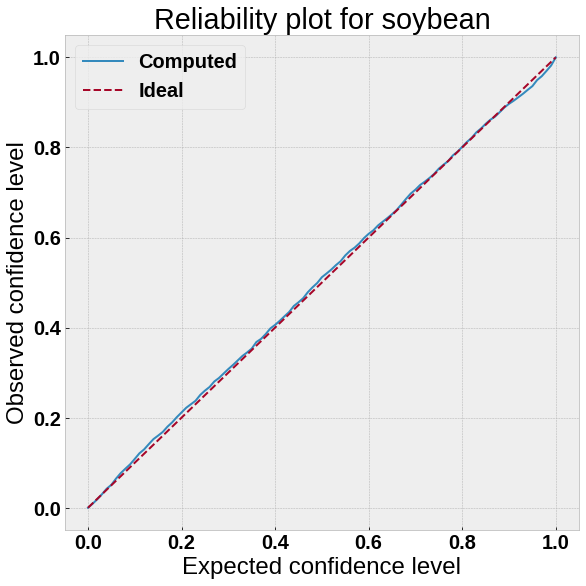

In [46]:
df = evaluate(model, data['X_test'], data['y_test'], data['y_scaler'])
plot_reliability(df, crop, data['y_scaler'], step=.01)

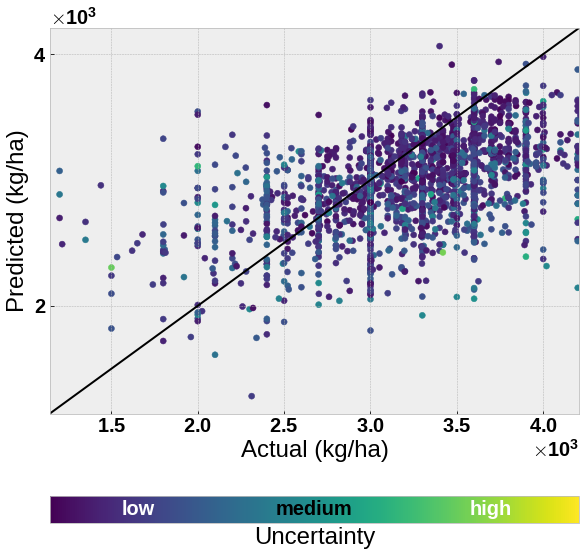

In [45]:
plot_scatter(df, crop, data['y_scaler'])

In [50]:
study.best_trial.params

{'entropy': 0.23593780932738875,
 'gamma': 0.7014728817844712,
 'noise': 0.08240805644091724,
 'α': 9.813691912738821e-05}